# Semantic Segmentation 

Courtesy : https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/


Semantic segmentation algorithms attempt to:

Partition the image into meaningful parts
While at the same time, associate every pixel in an input image with a class label (i.e., person, road, car, bus, etc.).
The semantic segmentation architecture we’re using is <b> ENet </b>, which is based on Paszke et al.’s 2016 publication, ENet: A Deep Neural Network Architecture for Real-Time Semantic Segmentation.(https://arxiv.org/abs/1606.02147)

One of the primary benefits of ENet is that it’s fast — up to 18x faster and requiring 79x fewer parameters with similar or better accuracy than larger models. The model size itself is only 3.2MB!

In [3]:
#A series of convenience functions to make basic image processing operations such as translation, rotation, resizing, skeletonization, 
#and displaying Matplotlib images easier with OpenCV and Python.Created by Adrian Rosebrock of pyimagesearch 
!pip install imutils

  Running setup.py bdist_wheel for imutils: started
  Running setup.py bdist_wheel for imutils: finished with status 'done'
  Stored in directory: C:\Users\vinit\AppData\Local\pip\Cache\wheels\b2\40\59\139d450e68847ef2f27d876d527b13389dac23df0f66526b5d
Successfully built imutils


You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import time
import cv2

In [2]:
cv2.__version__

'4.0.0'

In [2]:
# load the class label names
CLASSES = open('enet-cityscapes/enet-classes.txt').read().strip().split("\n")

In [4]:
CLASSES

['Unlabeled',
 'Road',
 'Sidewalk',
 'Building',
 'Wall',
 'Fence',
 'Pole',
 'TrafficLight',
 'TrafficSign',
 'Vegetation',
 'Terrain',
 'Sky',
 'Person',
 'Rider',
 'Car',
 'Truck',
 'Bus',
 'Train',
 'Motorcycle',
 'Bicycle']

In [3]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(CLASSES) - 1, 3),dtype="uint8")
COLORS = np.vstack([[0, 0, 0], COLORS]).astype("uint8")
# initialize the legend visualization
legend = np.zeros(((len(CLASSES) * 25) + 25, 300, 3), dtype="uint8")
 
# loop over the class names + colors
for (i, (className, color)) in enumerate(zip(CLASSES, COLORS)):
# draw the class name + color on the legend
    color = [int(c) for c in color]
    cv2.putText(legend, className, (5, (i * 25) + 17),
    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.rectangle(legend, (100, (i * 25)), (300, (i * 25) + 25),tuple(color), -1)

In [4]:
# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNet('enet-cityscapes/enet-model.net')

[INFO] loading model...


OpenCV provides two functions to facilitate image preprocessing for deep learning cassification:

    cv2.dnn.blobFromImage
    cv2.dnn.blobFromImages
    
These two functions perform

    Mean subtraction
    Scaling
    And optionally channel swapping

In [5]:
# load the input image, resize it, and construct a blob from it,
# but keeping mind mind that the original input image dimensions
# ENet was trained on was 1024x512
image = cv2.imread('opencv-semantic-segmentation/opencv-semantic-segmentation/images/example_01.png')
image = imutils.resize(image, width=500)
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (1024, 512), 0, swapRB=True, crop=False)

In [6]:
# perform a forward pass using the segmentation model
net.setInput(blob)
start = time.time()
output = net.forward()
end = time.time()

In [7]:
# show the amount of time inference took
print("[INFO] inference took {:.4f} seconds".format(end - start))

[INFO] inference took 0.4338 seconds


In [8]:
# infer the total number of classes along with the spatial dimensions
# of the mask image via the shape of the output array
(numClasses, height, width) = output.shape[1:4]

In [9]:
numClasses

20

In [10]:
# our output class ID map will be num_classes x height x width in
# size, so we take the argmax to find the class label with the
# largest probability for each and every (x, y)-coordinate in the
# image
classMap = np.argmax(output[0], axis=0)

In [11]:
classMap

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [12]:
mask = COLORS[classMap]

In [13]:
mask.shape

(512, 1024, 3)

In [14]:
# resize the mask and class map such that its dimensions match the
# original size of the input image (we're not using the class map
# here for anything else but this is how you would resize it just in
# case you wanted to extract specific pixels/classes)
mask = cv2.resize(mask, (image.shape[1], image.shape[0]),
	interpolation=cv2.INTER_NEAREST)

In [16]:
mask.shape

(250, 500, 3)

In [17]:
classMap = cv2.resize(classMap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
classMap.shape

(250, 500)

In [18]:
# perform a weighted combination of the input image with the mask to
# form an output visualization
output = ((0.4 * image) + (0.6 * mask)).astype("uint8")

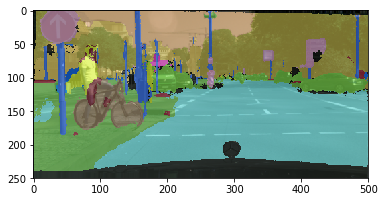

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(output)

In [20]:
# loop over each of the individual class IDs in the image
for classID in np.unique(classMap):
	# build a binary mask for the current class and then use the mask
	# to visualize all pixels in the image belonging to the class
	print("[INFO] class: {}".format(CLASSES[classID]))
	classMask = (mask == COLORS[classID]).astype("uint8") * 255
	classMask = classMask[:, :, 0]
	classOutput = cv2.bitwise_and(image, image, mask=classMask)
	classMask = np.hstack([image, classOutput])

[INFO] class: Unlabeled
[INFO] class: Road
[INFO] class: Sidewalk
[INFO] class: Building
[INFO] class: Wall
[INFO] class: Fence
[INFO] class: Pole
[INFO] class: TrafficLight
[INFO] class: TrafficSign
[INFO] class: Vegetation
[INFO] class: Terrain
[INFO] class: Sky
[INFO] class: Person
[INFO] class: Rider
[INFO] class: Car
[INFO] class: Truck
[INFO] class: Bicycle


In [24]:
# wow it detected everything but "person" ..
#The dataset Cityscapes contains images recorded for urban scene understanding, it cannot identify people up close..bummer!